<a href="https://colab.research.google.com/github/PhaniChandraSekhar/AIML_Practice/blob/main/AIML_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recurrent Neural Network (RNN/LSTM)**

**Category: **Deep Learning (Supervised)

**Description:**
Neural networks designed to work with sequential data, maintaining internal memory.

**Key Components:**
- Memory Cells: LSTM or GRU units
- Gates: Input, Forget, Output
- Sequential Processing

**Example Application:**

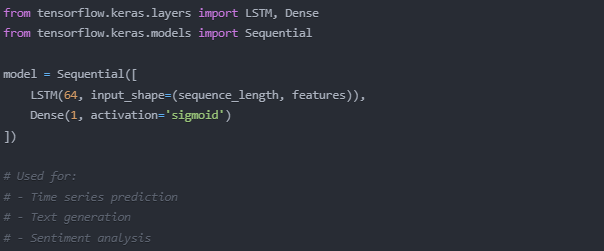


**Best Used For:**
- Natural language processing
- Time series forecasting
- Speech recognition
- Machine translation


**Code implementatiuon steps:**
**Data Analysis: **

Time series visualization
Statistical analysis
Moving averages
Daily returns analysis


**Model Implementation:**

Bidirectional LSTM layers
Dropout for regularization
Sequence creation
Early stopping and checkpointing


**Evaluation Metrics:**

RMSE, MAE, R² scores
Training/validation loss curves
Prediction visualization
Future predictions


**Visualizations:**

Time series plots
Distribution analysis
Correlation heatmaps
Prediction vs actual comparisons
Future predictions

**Future things to do:**
1. Add different LSTM architectures?
2. Include more feature engineering?
3. Add attention mechanisms?
4. Implement different prediction strategies?
5. Add more advanced visualizations?

In [ ]:
#Set up Kaggle credentials:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download the dataset:
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
!unzip stock-time-series-20050101-to-20171231.zip

In [ ]:
# Install required libraries
!pip install tensorflow pandas numpy matplotlib seaborn scikit-learn plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class TimeSeriesLSTM:
    def __init__(self, sequence_length=60):
        """Initialize Time Series LSTM Analyzer"""
        self.df = None
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler()
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.model = None
        self.history = None

    def load_data(self):
        """Load Stock Market Dataset"""
        # For Colab, first upload the dataset or use these commands:
        '''
        !pip install kaggle
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
        !unzip stock-time-series-20050101-to-20171231.zip
        '''

        # Load data
        self.df = pd.read_csv('g_stock_prices.csv')
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df.set_index('Date', inplace=True)

        print("Dataset Shape:", self.df.shape)
        print("\nSample Data:")
        print(self.df.head())

        return self.df

    def explore_data(self):
        """Perform exploratory data analysis"""

        # 1. Time Series Plot
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df['Close'])
        plt.title('Stock Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.grid(True)
        plt.show()

        # 2. Distribution of Close Prices
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df['Close'], kde=True)
        plt.title('Distribution of Close Prices')
        plt.show()

        # 3. Daily Returns
        daily_returns = self.df['Close'].pct_change()
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, daily_returns)
        plt.title('Daily Returns')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.grid(True)
        plt.show()

        # 4. Correlation Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation Matrix')
        plt.show()

        # 5. Moving Averages
        ma_periods = [7, 30, 90]
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price')
        for period in ma_periods:
            ma = self.df['Close'].rolling(window=period).mean()
            plt.plot(self.df.index, ma, label=f'{period}-day MA')
        plt.title('Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    def prepare_sequences(self, data):
        """Create sequences for LSTM"""
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:(i + self.sequence_length)])
            y.append(data[i + self.sequence_length])
        return np.array(X), np.array(y)

    def preprocess_data(self):
        """Preprocess data for LSTM"""
        # Scale the data
        data = self.scaler.fit_transform(self.df[['Close']])

        # Create sequences
        X, y = self.prepare_sequences(data)

        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        self.X_train, self.X_test = X[:train_size], X[train_size:]
        self.y_train, self.y_test = y[:train_size], y[train_size:]

        print("Training set shape:", self.X_train.shape)
        print("Testing set shape:", self.X_test.shape)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self):
        """Build LSTM model"""
        self.model = Sequential([
            Bidirectional(LSTM(50, return_sequences=True),
                         input_shape=(self.sequence_length, 1)),
            Dropout(0.2),
            Bidirectional(LSTM(50, return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(50)),
            Dropout(0.2),
            Dense(1)
        ])

        self.model.compile(optimizer='adam', loss='mse')
        print(self.model.summary())

        return self.model

    def train_model(self, epochs=50, batch_size=32):
        """Train LSTM model"""
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        checkpoint = ModelCheckpoint(
            'best_model.h5',
            monitor='val_loss',
            save_best_only=True
        )

        # Train model
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping, checkpoint],
            verbose=1
        )

        return self.history

    def evaluate_model(self):
        """Evaluate model performance"""
        # Make predictions
        train_predictions = self.model.predict(self.X_train)
        test_predictions = self.model.predict(self.X_test)

        # Inverse transform predictions
        train_predictions = self.scaler.inverse_transform(train_predictions)
        test_predictions = self.scaler.inverse_transform(test_predictions)
        y_train_inv = self.scaler.inverse_transform(self.y_train)
        y_test_inv = self.scaler.inverse_transform(self.y_test)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predictions))
        test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predictions))
        train_mae = mean_absolute_error(y_train_inv, train_predictions)
        test_mae = mean_absolute_error(y_test_inv, test_predictions)
        train_r2 = r2_score(y_train_inv, train_predictions)
        test_r2 = r2_score(y_test_inv, test_predictions)

        print("\nModel Performance Metrics:")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")

        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot predictions
        plt.figure(figsize=(15, 6))
        train_dates = self.df.index[self.sequence_length:len(self.X_train)+self.sequence_length]
        test_dates = self.df.index[len(self.X_train)+self.sequence_length:]

        plt.plot(train_dates, y_train_inv, label='Actual (Train)')
        plt.plot(train_dates, train_predictions, label='Predicted (Train)')
        plt.plot(test_dates, y_test_inv, label='Actual (Test)')
        plt.plot(test_dates, test_predictions, label='Predicted (Test)')

        plt.title('Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot prediction vs actual scatter
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_train_inv, train_predictions, alpha=0.5)
        plt.plot([y_train_inv.min(), y_train_inv.max()],
                [y_train_inv.min(), y_train_inv.max()], 'r--')
        plt.title('Train: Predicted vs Actual')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')

        plt.subplot(1, 2, 2)
        plt.scatter(y_test_inv, test_predictions, alpha=0.5)
        plt.plot([y_test_inv.min(), y_test_inv.max()],
                [y_test_inv.min(), y_test_inv.max()], 'r--')
        plt.title('Test: Predicted vs Actual')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')

        plt.tight_layout()
        plt.show()

    def make_future_predictions(self, steps=30):
        """Make future predictions"""
        last_sequence = self.X_test[-1:]
        predictions = []

        for _ in range(steps):
            # Predict next value
            next_pred = self.model.predict(last_sequence)
            predictions.append(next_pred[0])

            # Update sequence
            last_sequence = np.roll(last_sequence, -1)
            last_sequence[0, -1] = next_pred

        # Inverse transform predictions
        predictions = np.array(predictions)
        predictions = self.scaler.inverse_transform(predictions)

        # Create future dates
        last_date = self.df.index[-1]
        future_dates = pd.date_range(start=last_date, periods=steps+1)[1:]

        # Plot predictions
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df['Close'], label='Historical Data')
        plt.plot(future_dates, predictions, label='Future Predictions', linestyle='--')
        plt.title('Future Stock Price Predictions')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        return pd.DataFrame(predictions, index=future_dates, columns=['Predicted_Price'])


In [ ]:
def main():
    # Create instance of TimeSeriesLSTM
    ts_lstm = TimeSeriesLSTM()

    # Step 1: Load data
    print("Step 1: Loading data...")
    ts_lstm.load_data()

    # Step 2: Explore data
    print("\nStep 2: Exploring data...")
    ts_lstm.explore_data()

    # Step 3: Preprocess data
    print("\nStep 3: Preprocessing data...")
    ts_lstm.preprocess_data()

    # Step 4: Build model
    print("\nStep 4: Building LSTM model...")
    ts_lstm.build_model()

    # Step 5: Train model
    print("\nStep 5: Training model...")
    ts_lstm.train_model()

    # Step 6: Evaluate model
    print("\nStep 6: Evaluating model...")
    ts_lstm.evaluate_model()

    # Step 7: Make future predictions
    print("\nStep 7: Making future predictions...")
    future_predictions = ts_lstm.make_future_predictions()
    print("\nFuture Predictions:")
    print(future_predictions)

if __name__ == "__main__":
    main()